<center><img src='https://drive.google.com/uc?id=1PioHCAlQTt8LWChoMysPErSOrxOfAW0R'></center>

**AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020**

---
<center>
<h1>Przetwarzanie multimediów w systemach decyzyjnych,</br>Informatyka</br> specjalność: uczenie maszynowe

Autor: Przemysław Rośleń</br>

</br>

21 października 2021
</center>
<h3>Uczenie wielozadaniowe w widzeniu komputerowym, cz. 2</h2>


# Wprowadzenie

W ramach laboratorium kontynuowane jest praktyczne zapoznanie z metodami i możliwościami **uczenia wielozadaniowego**.

Celem laboratorium jest:

- przygotowanie nowych danych dla zbioru obrazów CIFAR-10 (10 klas przedmiotów, obrazy kolorowe 32·32 piksele) i dla zadania regresji - wyliczania wartości koloru (ang. `hue`) ze średnich wartości pikseli obrazów w przestrzeni kolorów R,G,B,
- przygotowanie, trening i test architektury jednozadaniowej, dedykowanej do regresji - określania wartości `hue`
- przygotowanie, trening i test architektury jednozadaniowej, dedykowanej oryginalnemu zadaniu: klasyfikacji obrazów do jednej z 10 klas
- połączenie obu zadań w scenariuszu uczenia wielozadaniowego: dyskusja i propozycja `loss` oraz metryki dokładności
- optymalizacja scenariusza poprzez zastosowanie pre-trenowania, rozbudowania architektury, zamrożenia wag wybranej części architektury, dotrenowanie i test uzyskiwanego modelu.

# Zagadnienia teoretyczne

Optymalny trening modeli wymaga doboru właściwych wartości hiperparametrów. Część pierwsza dotyczyła budowy i testowania odmiennych architektur, część druga, obecnie realizowana, wymaga doboru wag indywidualnych funkcji loss w obu zadaniach, doboru tempa uczenia, doboru warstw poddawanych zamrożeniu i innych.

## Dobór wag loss

Trening modelu przebiega w oparciu o obserwację zmian funkcji loss. W uczeniu wielozadaniowym loss jest wieloskładnikowy, tj. wymaga wyliczenia sumy, sumy ważonej lub innej skumulowanej wartości, wyrażającej poprawę modelu w jednoczesnej realizacji obu zadań.

Jeśli zadania mają odmienną naturę, np. regresja i klasyfikacja, to sposób pomiaru ich działania będzie odmienny. Zarówno metryki (błąd średni, błąd średniokwadratowy, dokładność klasyfikacji, itd.) jak i loss będą odmienne i dobrane muszą być z rozwagą i celowo.

Wskazówka praktyczna: warto stworzyć i rozpocząć trening modelu jednozadaniowego, aby zaobserwować wartości loss i błędów, zachodzące dla danego zagadnienia. Różnice w skalach wartości mogą być korygowane **doborem odpowiednich wag dla loss**.

Brak zbalansowania między wagami prowadzi do lepszej i szybszej nauki jednego z zadań kosztem pomijania poprawy w treningu drugiego zadania.

## Dobór prędkości nauki

Wartość *learning rate* jest jednym z najważniejszych hiperparametrów, wpływających na konwergencję modelu (zbieganie konsekwentne do stanu optymalnego). Dla odmiennych zadań wartość `lr` będzie generalnie różna. Odpowiednia dla jednego ale zbyt duża dla drugiego zadania, powodować będzie eksplozję gradientów i brak konwergencji. Odpowiednia dla drugiego ale zbyt mała dla pierwszego zadania, powodować będzie zbyt wolne tempo konwergencji i potrzebę wydłużenia procesu treningu.

Dostępne jest wiele różnorodnych scenariuszy *multi-task learning*, które pozwalają na przykład na naprzemienny trening części większego modelu danymi jednego i drugiego zadania. Więcej: *Alternate training, MTL in tensorflow:* https://jg8610.github.io/Multi-Task/

# Wymagania wstępne

Wykonanie laboratorium należy rozpocząć od **przypomnienia zagadnień z pierwszej części**, realizowanej na poprzednich zajęciach. W instrukcji do cz. 1 dostępne są opisy i wyjaśnienia, które są istotne dla scenariuszy uczenia wielozadaniowego i dla rozbudowy modeli, ale nie są tutaj ponownie zamieszczane.

# Przygotowanie środowiska

Następuje zaimportowanie wymaganych modułów z bibliotek tensorflow, keras i numpy.

In [ ]:
#importowanie bibliotek

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.utils import plot_model


In [ ]:
# pobranie zbioru danych
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 [==============================] - 2s 0us/step


# Wizualizacja danych


Dla przypomnienia: tensory (macierze wielowymiarowe) dla obrazów kolorowych posiadają 4 wymiary: numer próbki, kolumny, wiersze, numer kanału koloru. Dane wyjściowe także są tensorem, macierzą dwuwymiarową: numer próbki, numer cechy - w tym wypadku jedna klasa przydzielana obrazowi.

Zaobserwować można rozmiar wczytanych danych:

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
from matplotlib import pyplot
%matplotlib inline

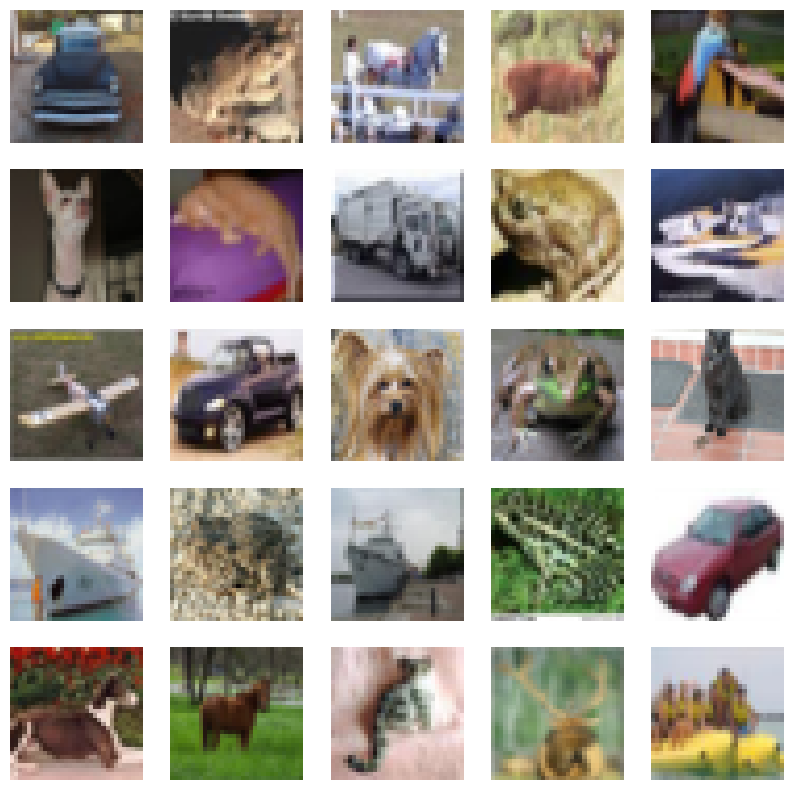

In [ ]:
fig, axes = pyplot.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(x_train)))
        axes[j][k].set_axis_off()
        axes[j][k].imshow(x_train[i:i+1][0])

# Zadania dla uczenia wielozadaniowego

## Zadanie oryginalne

Na podstawie obrazów modele mają za zadanie określać jedną z 10 klas: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks. Dane wyjściowe `y_train` i `y_test` posiadają odpowiedni numer klasy (kodowanie wprost jedną liczbą `int`).

Klasyfikację wykonać można sieciami neuronowymi w pełni połączonymi lub splotowymi. Uzyskiwane wyniki to kilka procent błędów klasyfikacji (https://en.wikipedia.org/wiki/CIFAR-10#Research_papers_claiming_state-of-the-art_results_on_CIFAR-10).

## Zadanie dodatkowe

Na potrzeby scenariusza uczenia wielozadaniowego przygotowane zostaną nowe dane wyjściowe. Zadanie ma polegać na określaniu odcienia kolorów obrazu. W przestrzeni barw HSV pierwszy wymiar to odcień, ang. hue, jednoznaczny z tym, jak opisujemy kolor jednym słowem: czerwony, zielony, itp. Pozostałe, które tu są ignorowane to S-saturacja (nasycenie barwy - intensywna, blada) oraz V-value (jasność).

Skalę odcieni prezentuje poniższy rysunek, wartości wyrażane są w stopniach.

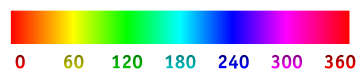

## Wyliczenie danych wyjściowych

W obrazie kolor zapisany jest jako mieszanina składowych modelu tzw. addytywnego, czerwonego, zielonego, niebieskiego - RGB. Konwersja polega na kilku prostych obliczeniach.

Poniższy kod najpierw uśrednia wartości R,G,B po wszytkich pikselach obrazu, następnie sprawdza, która ze średnich składowych jest maksymalna i od tego uzależnia sposób wyliczenia 'hue'. Jeśli obraz jest szary, wartości RGB są sobie równe, minimum jest równe maksimum, to domyślnie 'hue' przyjmuje wartość 0.

In [ ]:
def getHueLabels(dataset):
    color_labels=[1,2,3] #r g b
    datasetsize=dataset.shape[0]
    labels_color=np.zeros(datasetsize,dtype=int)
    for probka in range(datasetsize):
        # średnia r, g, b po wszystkich pikselach
        kolory=sum(dataset[probka][0])/(255)

        # obliczenia do konwersji z r, g, b na Hue (odcień)
        maksimum=max(kolory)
        minimum=min(kolory)
        if maksimum==minimum:
            continue #przerwać tę iterację for, Hue równy domyślne zero

        mmscale = 1/(maksimum-minimum)

        indeks=np.where(kolory==maksimum)[0][0]

        if indeks == 0: #red
            Hue = (kolory[1]-kolory[2])*mmscale
        if indeks == 1: #green
            Hue = 2.0 + (kolory[2]-kolory[0])*mmscale
        if indeks == 2: #blue
            Hue = 4.0 + (kolory[0]-kolory[1])*mmscale
        Hue = Hue * 60
        if Hue < 0:
            Hue = Hue + 360;
        labels_color[probka]=np.floor(Hue)
    return(labels_color.reshape(datasetsize,1))

Powyżej zdefiniowana funkcja użyta jest do wyliczenia z obrazów nowych wartości wyjściowych do treningu i testu. W colab przetworzenie 60000 obrazów zajmie około 3 sekundy.

In [ ]:
labels_color_train = getHueLabels(dataset = x_train)
labels_color_test = getHueLabels(dataset = x_test)

Sprawdzić można format uzyskanych danych i ich rozmiar.

In [ ]:
print(labels_color_train[0:25])
print(y_train[0:25])
print(labels_color_train.shape)
print(y_train.shape)

[[ 29]
 [123]
 [ 17]
 [ 41]
 [223]
 [ 17]
 [ 84]
 [156]
 [205]
 [ 13]
 [ 79]
 [216]
 [202]
 [  6]
 [210]
 [208]
 [201]
 [ 53]
 [350]
 [ 45]
 [180]
 [353]
 [ 28]
 [ 36]
 [ 43]]
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]
 [9]
 [3]
 [2]
 [6]
 [4]
 [3]
 [6]
 [6]
 [2]]
(50000, 1)
(50000, 1)


Porównajmy wyliczone nowe wartości (25 wartości hue i klas przedmiotów - powyżej) wyjściowe z treścią i kolorystyką obrazów.

Dla przypomnienia: kolejne klasy numerowane od zero to: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks.

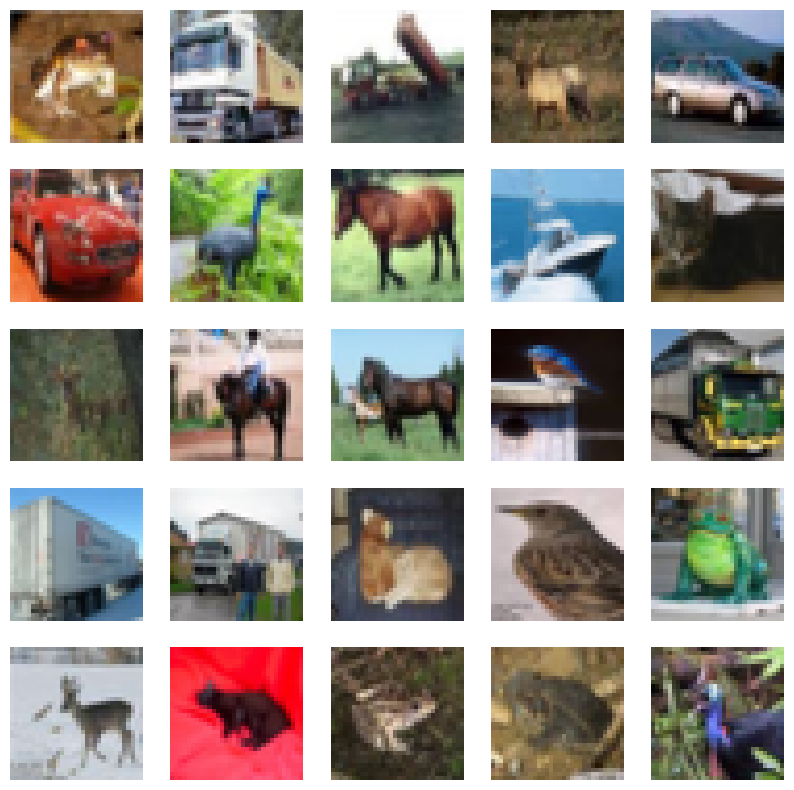

In [ ]:
fig, axes = pyplot.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = j*5+k
        axes[j][k].set_axis_off()
        axes[j][k].imshow(x_train[i:i+1][0])


# Model jednozadaniowy: regresja koloru

Należy zapoznać się z przykładową architekturą zdefiniowaną poniżej. Przedyskutuj dobór typów i rozmiaru warstw. Zaproponuj dowolne zmiany kierując się własną intuicją.

Model: "hue_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 198785 (776.50 KB)
Trainable params: 198785 (776.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


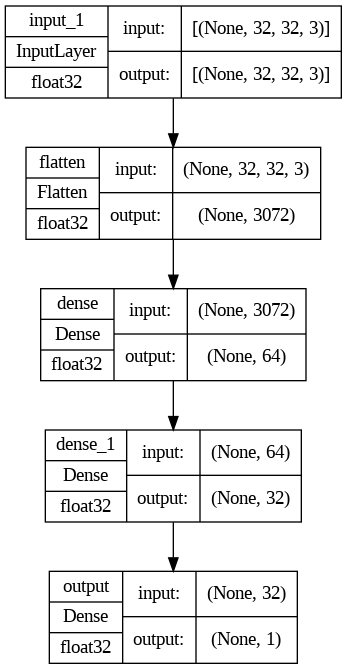

In [ ]:
inputs = tf.keras.Input(shape=(32,32,3))      # warstwa wejściowa

#x = layers.Conv2D(filters = 3,kernel_size=3)(inputs)
#x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # warstwa ukryta
x = layers.Dense(32, activation="relu")(x) # warstwa ukryta
outputs = layers.Dense(1, name="output")(x)    # wyjście


model = tf.keras.Model(inputs=inputs, outputs=outputs, name="hue_model")
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True,
           show_dtype=True)


### Komentarz

Można dodać *Conv2D* i *Pooling* przed warstwami *Dense*.

Przykładowy `optimizer` z zadanym `lr` oraz `loss` i metryka są następujące:

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #optimizer='sgd',
    loss='mse',
    metrics=tf.keras.metrics.MeanSquaredError(),
)


## Trening modelu

W celu szybkiego treningu modelu, który może mieć 200000 wag, zaleca się przełączenie środowiska wykonawczego na GPU.

In [ ]:
history = model.fit(x_train, labels_color_train, batch_size=64, epochs=10, validation_split=0.2)

#test_scores = model.evaluate(x_test, labels_color_test, verbose=2)
#print("Test loss:", test_scores[0])
#print("Test accuracy:", test_scores[1])

Epoch 1/10
625/625 [==============================] - 6s 4ms/step - loss: 7071.3672 - mean_squared_error: 7071.3672 - val_loss: 6029.2666 - val_mean_squared_error: 6029.2666
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 5934.2593 - mean_squared_error: 5934.2593 - val_loss: 6157.2402 - val_mean_squared_error: 6157.2402
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 5407.4834 - mean_squared_error: 5407.4834 - val_loss: 5091.8604 - val_mean_squared_error: 5091.8604
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 4938.8652 - mean_squared_error: 4938.8652 - val_loss: 5643.4492 - val_mean_squared_error: 5643.4492
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 4602.8662 - mean_squared_error: 4602.8662 - val_loss: 4546.9761 - val_mean_squared_error: 4546.9761
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 4240.4087 - mean_squared_error: 4240.4087 - val_loss: 48

## Ocena modelu

Zaobserwować należy przebieg zmian `loss`.

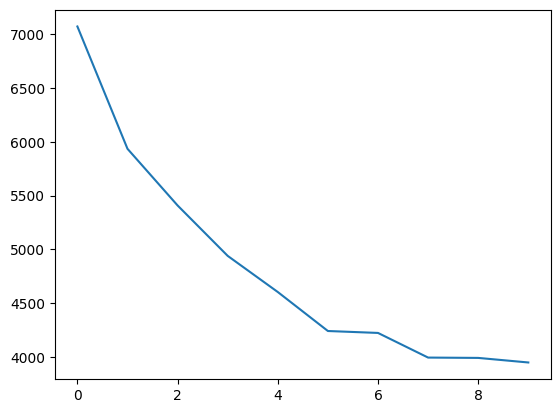

In [ ]:
pyplot.plot(history.history['loss'])

Wynik ewaluacji na całym zbiorze testowym.

In [ ]:
model.evaluate(x_test,labels_color_test)

313/313 [==============================] - 1s 3ms/step - loss: 3810.8479 - mean_squared_error: 3810.8479


[3810.847900390625, 3810.847900390625]

Rozważyć należy jaki jest faktyczny błąd, jeśli pod koniec treningu średni błąd kwadratowy wynosi kilka tysięcy.

Zbadać można jaki jest wynik dla wybranego obrazu ze zbioru testowego(wyświetlana jest wartość przewidywana przez model oraz prawdziwa).

In [ ]:
probka=12
result=model.predict(x_test[probka:probka+1,])
print(result[0])
print(labels_color_test[probka])

1/1 [==============================] - 0s 120ms/step
[61.265034]
[39]


## Zadanie do wykonania

Należy zmodyfikować model, dodając np. warstwy dropout, zmieniając liczbę neuronów w warstwach i liczbę warstw. Zastosować można także (jako pierwszą warstwę) warstwę splotową. Ostatecznie uzyskany model powinien osiągać zadawalającą dokładność regresji wartości `hue` oraz nie być nadmiernie złożony.

Znaczenie określenia "nadmierna złożoność" powinno wynikać z intuicyjnego rozumienia zadania, które model ma realizować. Dane wyjściowe powyżej zostały za pomocą bardzo prostego algorytmu wygenerowane na podstawie pikseli obrazu. Wymagały sumowania (trzy razy 1024), znalezienia maksimum i minimum w wektorze 3 wartości, sumy i dzielenia. Model o podobnych możliwościach nie powinien zawierać więcej niż kilkanaście tysięcy wag.

### Zadanie 1

Model: "hue_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 3)         84        
                                                                 
 average_pooling2d_16 (Aver  (None, 15, 15, 3)         0         
 agePooling2D)                                                   
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 3)         84        
                                                                 
 average_pooling2d_17 (Aver  (None, 6, 6, 3)           0         
 agePooling2D)                                                   
                                                                 
 flatten_9 (Flatten)         (None, 108)               0 

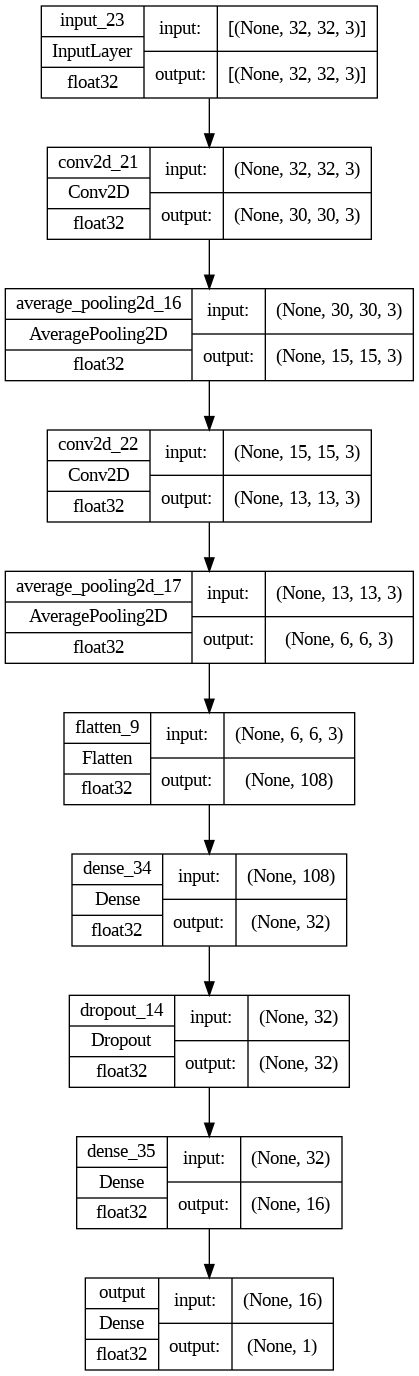

In [ ]:
inputs = tf.keras.Input(shape=(32,32,3))      # warstwa wejściowa

x = layers.Conv2D(3, (3, 3))(inputs)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(3, (3, 3))(x)
x = layers.AveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, name="output")(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name="hue_model")
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True,
           show_dtype=True)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #optimizer='sgd',
    loss='mse',
    metrics=tf.keras.metrics.MeanSquaredError(),
)


In [ ]:
history = model.fit(x_train, labels_color_train, batch_size=64, epochs=10, validation_split=0.2)

#test_scores = model.evaluate(x_test, labels_color_test, verbose=2)
#print("Test loss:", test_scores[0])
#print("Test accuracy:", test_scores[1])

Epoch 1/10
625/625 [==============================] - 5s 5ms/step - loss: 6985.6694 - mean_squared_error: 6985.6694 - val_loss: 6026.5190 - val_mean_squared_error: 6026.5190
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 5891.2168 - mean_squared_error: 5891.2168 - val_loss: 5566.2910 - val_mean_squared_error: 5566.2910
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 5776.3564 - mean_squared_error: 5776.3564 - val_loss: 5510.4370 - val_mean_squared_error: 5510.4370
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 5490.9678 - mean_squared_error: 5490.9678 - val_loss: 4798.9390 - val_mean_squared_error: 4798.9390
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 4662.7852 - mean_squared_error: 4662.7852 - val_loss: 3871.8159 - val_mean_squared_error: 3871.8159
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 4084.3528 - mean_squared_error: 4084.3528 - val_loss: 35

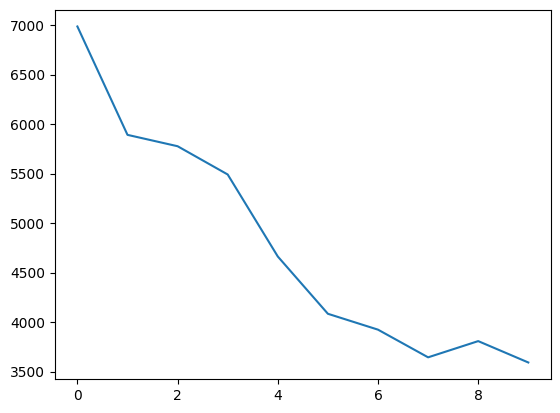

In [ ]:
pyplot.plot(history.history['loss'])

In [ ]:
model.evaluate(x_test,labels_color_test)

313/313 [==============================] - 1s 2ms/step - loss: 2933.2427 - mean_squared_error: 2933.2427


[2933.24267578125, 2933.24267578125]

### Wnioski

Dodanie warstw *Conv2D* i *Poolingu* przed warstwami *Dense* (i zmniejszenie warstw *Dense*) pozwoliło na znaczne poprawienie dokładności modelu przy jednocześnie mniejszej liczbie wag.

# Model jednozadaniowy: klasyfikacja obrazu siecią splotową

Na potrzeby klasyfikacji i poprawnego wyliczania loss i accuracy dane wyjściowe zmienione zostaną z kodowania wprost na kodowanie one-hot.

In [ ]:
nb_classes = 10 # number of unique image classes

Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_test = tf.keras.utils.to_categorical(y_test, nb_classes)
print(Y_train[0:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


Poniżej jako argumenty do definicji warstw podawane są nienazwane parametry, jednakże zachowana jest kolejność:

- pierwszy argument - liczba filtrów,
- drugi argument - rozmiar kwadratowego kernela, np. 3 oznacza 3x3.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 9, 9, 64)          36928     
                                                                 
 conv2d_30 (Conv2D)          (None, 9, 9, 64)          36928     
                                                           

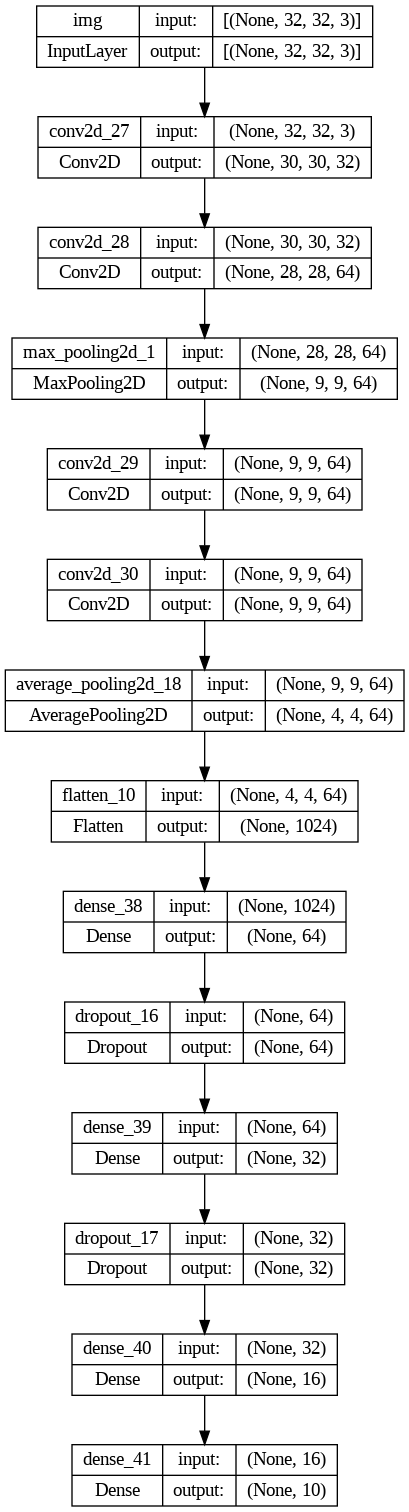

In [ ]:
inputs_im = tf.keras.Input(shape=(32, 32, 3), name="img")
# layers.Conv2D - własne zadanie: sprawdzić dokumentację przez użycie 'tooltip' i autouzupełniania
x_im = layers.Conv2D(32, 3, activation="relu")(inputs_im)
x_im = layers.Conv2D(64, 3, activation="relu")(x_im)
x_im = layers.MaxPooling2D(3)(x_im)

x_im = layers.Conv2D(64, 3, activation="relu", padding="same")(x_im)
x_im = layers.Conv2D(64, 3, activation="relu", padding="same")(x_im)
x_im = layers.AveragePooling2D()(x_im)
x_im = layers.Flatten()(x_im)
x_im = layers.Dense(64, activation="relu")(x_im)
x_im = layers.Dropout(0.2)(x_im)
x_im = layers.Dense(32, activation="relu")(x_im)
x_im = layers.Dropout(0.2)(x_im)
x_im = layers.Dense(16, activation="relu")(x_im)

outputs_im = layers.Dense(10)(x_im)

model_im = tf.keras.Model(inputs_im, outputs_im)
model_im.summary()
tf.keras.utils.plot_model(model_im, show_shapes=True)

In [ ]:
model_im.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)

## Trening i ocena modelu

Uwaga: dane wyjściowe one-hot nazwane są zmienną `Y_train` i `Y_test` (wielką literą, w odróżnieniu od `y_train` i `y_test`, które zawiera int, kodowanie wprost).


Na potrzeby nauki można zmienić środowisko wykonawcze w colab na GPU.

In [ ]:
model_im.fit(x_train, Y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 7s 9ms/step - loss: 1.9311 - acc: 0.2815 - val_loss: 1.5413 - val_acc: 0.4369
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 1.5202 - acc: 0.4502 - val_loss: 1.3089 - val_acc: 0.5371
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 1.2986 - acc: 0.5398 - val_loss: 1.1656 - val_acc: 0.5789
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 1.1538 - acc: 0.5971 - val_loss: 1.0671 - val_acc: 0.6302
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 1.0402 - acc: 0.6400 - val_loss: 0.9536 - val_acc: 0.6671
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.9414 - acc: 0.6806 - val_loss: 0.8687 - val_acc: 0.6968
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.8764 - acc: 0.7044 - val_loss: 0.8066 - val_acc: 0.7253
Epoch 8/10
625/625 [==============================] - 4s 7ms/step - loss: 0.

In [ ]:
score = model_im.evaluate(x_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.7757 - acc: 0.7435
Test score: 0.7757332921028137
Test accuracy: 0.7434999942779541


## Zadanie do wykonania

Należy model splotowy zmodyfikować i uzasadnić krótko wprowadzone zmiany. Oczekiwane `Test accuracy` jest na poziomie powyżej 0.72.

Należy zwrócić uwagę na `loss` dla obu modeli. Różnią się one o kilka rzędów wielkości i powinno być to odpowiednio zaadresowane doborem wag w uczeniu wielozadaniowym.

# Wyniki

Zwiększyliśmy liczbę warstw *Dense* przy zmniejszeniu ich wielkości. Zmnieniliśmy również *GlobalAveragePooling2D* na *AveragePooling2D*. Dodaliśmy warstwy *Dropout(0.2)* pomiędzy warstwami *Dense*. Pozwoliło to na zwiększenie dokładności do ponad 74 %.

# Uczenie wielozadaniowe

Model wielozadaniowy w tym ćwiczeniu laboratoryjnym wykorzystywać będzie pretrenowaną sieć splotową do klasyfikacji obrazu, wykonaną w ostatnim kroku powyżej (`model_im`).


## Modyfikacja pretrenowanego modelu

Raz wytrenowany model można modyfikować, zmieniając jego architekturę. Warstwy, które pozostaną nienaruszone będą miały wartości wag, takie jak obliczone w procesie nauki. Nowe warstwy inicjowane będą losowo.

Aby zmodyfikować model konieczne jest odwoływanie się do jego wybranych warstw. Służy do tego struktura `layers`, zawierająca wszystkie warstwy modelu, iterowalna numerem warstwy.

In [ ]:
model_im.layers

Poniżej zauważyć można w jaki sposób odwołać się do konkretnej warstwy i odczytać jej pola, np. nazwę.

In [ ]:
print(model_im.layers[0].name)
print(model_im.layers[1].name)
print(model_im.layers[2].name)
print(model_im.layers[3].name)
print(model_im.layers[4].name)

img
conv2d_27
conv2d_28
max_pooling2d_1
conv2d_29


Metoda `get_layer` wydobywa z modelu warstwę o podanej nazwie. Następnie wyjście tej warstwy można wykorzystać do dobudowania nowych elementów do architektury modelu.

UWAGA: poniższy przykład nie jest związany z rozważanym scenariuszem praktycznym, służy wyłącznie jako zobrazowanie możliwości modyfikacji.

In [ ]:
new_layers=(model_im.get_layer('conv2d_29').output)
new_layers=layers.Flatten()(new_layers)
new_layers_A=layers.Dense(1)(new_layers)

new_layers_B=layers.Dense(10)(new_layers)
new_layers_B=layers.Dense(10)(new_layers_B)

model_mod = tf.keras.Model(inputs=inputs_im, outputs=[new_layers_A, new_layers_B], name="temp_model")

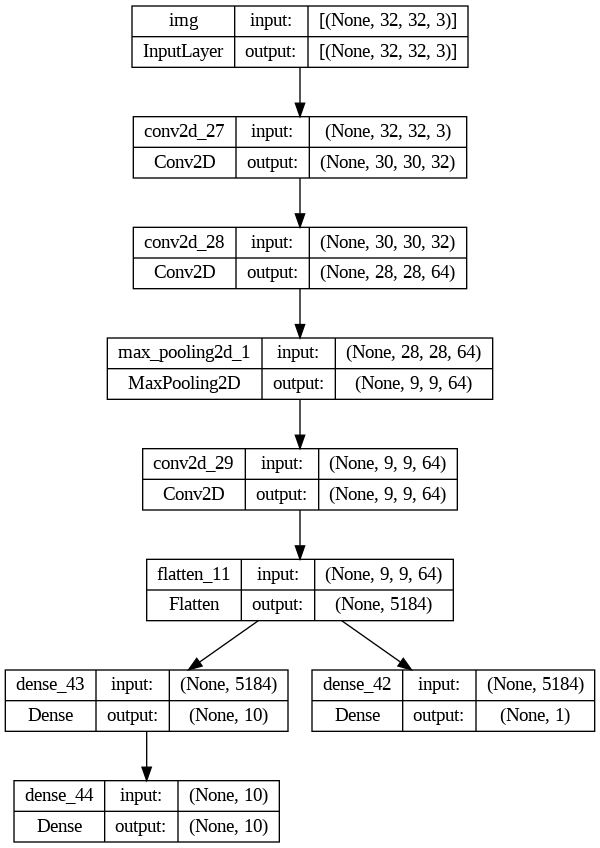

In [ ]:
plot_model(model_mod,show_shapes=True)

## Zamrażanie warstw modelu

Jeśli nowa architektura bazować ma na innej, **wcześniej wytrenowanej** do realizacji jednego zadania, to wartości wag współdzielonej cześci nie powinny podlegać istotnym zmianom w dalszych etapach nauki.

Istnieje możliwość zablokowania, "zamrożenia" wartości wag w modelu, poprzez ustawienie pola `trainable` wybranej warstwy. Wszystkie warstwy znajdujące się w modelu powyżej niej wyłączone zostaną z optymalizacji wag.

In [ ]:
model_mod.layers[2].trainable = True #domyślnie po utworzeniu modelu wszytkie warstwy mają True
print(model_mod.layers[2].trainable)
model_mod.layers[2].trainable = False
print(model_mod.layers[2].trainable)


True
False


UWAGA: Jeśli już model był zdefiniowany, skompilowany, uczony, a następnie zmodyfikowany i wybrane warstwy zostały zamrożone, to należy ponownie wykonać `compile`.

In [ ]:
model_mod.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.mean_squared_error ,tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=["acc"],
)

## Trening z zamrażaniem warstw

Dokumentacja biblioteki `Keras` opisuje wiele możliwości i podejść do treningu modelu do nowych zadań (uczenia transferowego): https://keras.io/guides/transfer_learning/.

To laboratorium nie dotyczy dokładnie uczenia transferowego, gdyż zakładamy, że początkowe zadanie cały czas ma być realizowane. Nie następuje zmiana dziedziny działania modelu, ale jej rozszerzenie o dodatkowe zadanie. Jednakże wytyczne zwiazane z uczeniem transferowym mają zastosowanie także w tym przypadku.

Zalecane jest przestrzeganie następującego scenariusza:

- model jednozadaniowy dla zadania bardziej złożonego jest definiowany i trenowany
- model ten rozbudowywany jest o nowe elementy do postaci wielozadaniowego modelu
- warstwy współdzielone między zadaniami powinny zostać zamrożone
- trenować należy w scenariuszu uczenia wielozadaniowego z `lr` dobranym jako wypadkowa między wartościami zalecanymi dla obu zadań
- w ostatnim kroku należy odblokować warstwy, ustawiając `trainable` na `True` i kontynuować trening z **bardzo małą wartością parametru** `lr`.

Dzieki powyższemu zapewnia się zachowanie wartości wag odpowiedzialnych za poprawne działanie dla pierwszego, bardziej złożonego zadania oraz celowe trenowanie elementów architektury odpowiedzialnych za drugie zadanie.



## Dobór hiperparametrów

W kodzie powyżej używane były przykładowe `optimizer` oraz `loss`. Można zaproponować własne lub uzasadnić obecny wybór, kierując się opisami:

- dobór metryki https://keras.io/api/metrics/
- dobór loss https://keras.io/api/losses/





# Zadanie do wykonania

Należy przygotować kod realizujący opisany powyżej scenariusz "Treningu z zamrażaniem warstw". Zadaniem głównym powinna być klasyfikacja obrazu, architektura to sieć splotowa, głęboka, odpowiednio wykorzystująca warstwy typu conv2d, pooling, dropout, flattening i dense.

Należy zidentyfikować w modelu miejsce dodania rozgałęzienia, odpowiedniego do realizacji drugiego zadania i rozbudować architekturę. W trakcie kompilacji modelu użyć należy właściwych wartości `loss_weights`.

Należy poprawnie wykorzystać zamrażanie warstw, trening z odpowiednią wartością `lr`, odmrożenie warstw, trening z bardzo małą wartoscią `lr`.

Po każdym etapie treningu należy wykreślać i obserwować `loss` oraz `test accuracy`.

### Zadanie 3

In [ ]:
new_layers = (model_im.get_layer('flatten_10').output)
x_hue = layers.Dense(64, activation="relu")(new_layers) # warstwa ukryta
x_hue = layers.Dense(32, activation="relu")(x_hue) # warstwa ukryta
outputs_hue = layers.Dense(1, name="output")(x_hue)    # wyjście

model_mod = tf.keras.Model(inputs=inputs_im, outputs=[outputs_im, outputs_hue], name="combined_model")

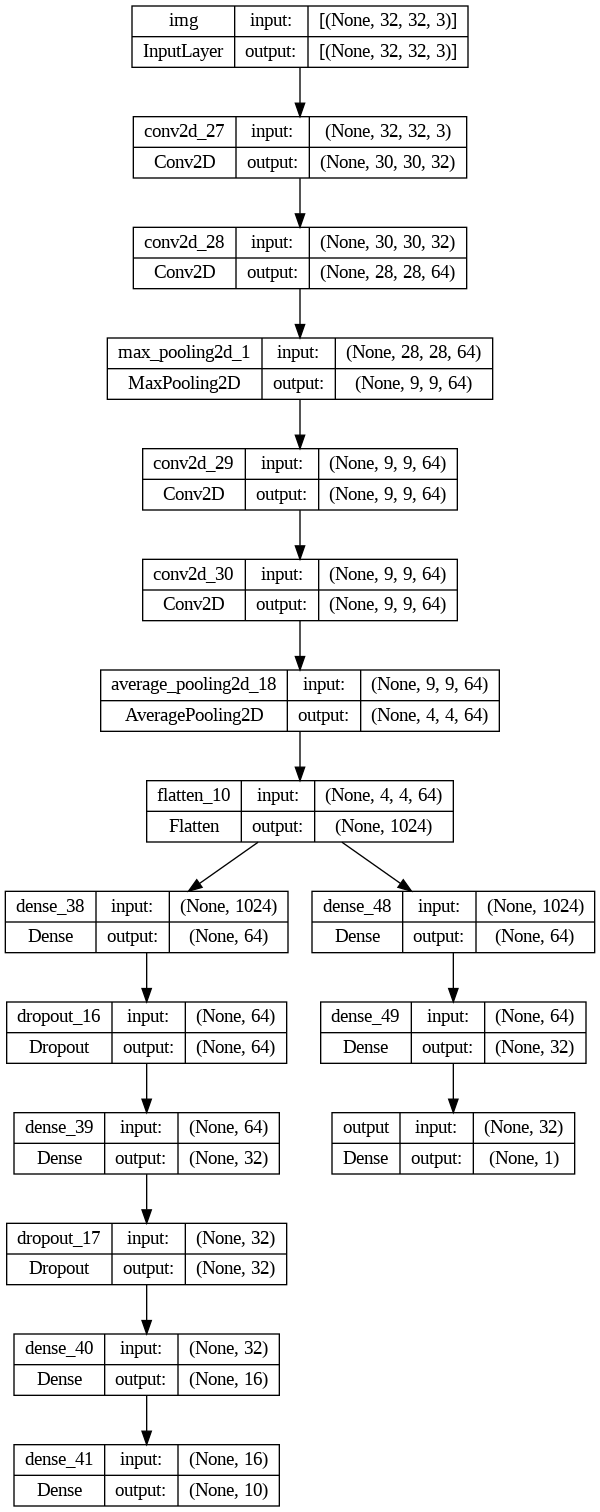

In [ ]:
plot_model(model_mod,show_shapes=True)

In [ ]:
model_mod.get_layer('conv2d_27').trainable = False
model_mod.get_layer('conv2d_28').trainable = False
model_mod.get_layer('max_pooling2d_1').trainable = False
model_mod.get_layer('conv2d_29').trainable = False
model_mod.get_layer('conv2d_30').trainable = False
model_mod.get_layer('average_pooling2d_18').trainable = False

In [ ]:
model_mod.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True), 'mse'],
    loss_weights=[4, 0.001],
    metrics=['acc', 'mse'],
)

In [ ]:
model_mod.fit(x_train, [Y_train, y_train], batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 7s 7ms/step - loss: 2.3820 - dense_41_loss: 0.5941 - output_loss: 5.5433 - dense_41_acc: 0.8030 - dense_41_mse: 43.1914 - output_acc: 0.1001 - output_mse: 5.5433 - val_loss: 2.8671 - val_dense_41_loss: 0.7157 - val_output_loss: 4.3543 - val_dense_41_acc: 0.7688 - val_dense_41_mse: 37.7501 - val_output_acc: 0.1043 - val_output_mse: 4.3543
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 2.2343 - dense_41_loss: 0.5576 - output_loss: 3.8810 - dense_41_acc: 0.8112 - dense_41_mse: 51.7075 - output_acc: 0.1058 - output_mse: 3.8810 - val_loss: 2.9102 - val_dense_41_loss: 0.7266 - val_output_loss: 3.9814 - val_dense_41_acc: 0.7699 - val_dense_41_mse: 52.4280 - val_output_acc: 0.1147 - val_output_mse: 3.9814
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 2.1620 - dense_41_loss: 0.5396 - output_loss: 3.5109 - dense_41_acc: 0.8199 - dense_41_mse: 62.0413 - output_acc: 0.1105 - output_mse: 3.5

In [ ]:
score = model_mod.evaluate(x_test, [Y_test, y_test])
score

313/313 [==============================] - 1s 4ms/step - loss: 3.1670 - dense_41_loss: 0.7910 - output_loss: 3.0584 - dense_41_acc: 0.7728 - dense_41_mse: 127.4316 - output_acc: 0.1157 - output_mse: 3.0584


[3.167023181915283,
 0.7909911870956421,
 3.058415174484253,
 0.7728000283241272,
 127.43162536621094,
 0.11569999903440475,
 3.058415174484253]

In [ ]:
model_mod.get_layer('conv2d_27').trainable = True
model_mod.get_layer('conv2d_28').trainable = True
model_mod.get_layer('max_pooling2d_1').trainable = True
model_mod.get_layer('conv2d_29').trainable = True
model_mod.get_layer('conv2d_30').trainable = True
model_mod.get_layer('average_pooling2d_18').trainable = True

In [ ]:
model_mod.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-4),
    loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True), 'mse'],
    loss_weights=[4, 0.001],
    metrics=['acc', 'mse'],
)

In [ ]:
history = model_mod.fit(x_train, [Y_train, y_train], batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 9s 10ms/step - loss: 1.6197 - dense_41_loss: 0.4044 - output_loss: 2.2135 - dense_41_acc: 0.8647 - dense_41_mse: 158.4155 - output_acc: 0.1225 - output_mse: 2.2135 - val_loss: 3.2094 - val_dense_41_loss: 0.8016 - val_output_loss: 3.1034 - val_dense_41_acc: 0.7747 - val_dense_41_mse: 142.1146 - val_output_acc: 0.1249 - val_output_mse: 3.1034
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 1.5515 - dense_41_loss: 0.3873 - output_loss: 2.1844 - dense_41_acc: 0.8691 - dense_41_mse: 165.5614 - output_acc: 0.1217 - output_mse: 2.1844 - val_loss: 3.2370 - val_dense_41_loss: 0.8085 - val_output_loss: 3.0698 - val_dense_41_acc: 0.7738 - val_dense_41_mse: 148.0407 - val_output_acc: 0.1231 - val_output_mse: 3.0698
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 1.5267 - dense_41_loss: 0.3811 - output_loss: 2.1645 - dense_41_acc: 0.8718 - dense_41_mse: 169.8389 - output_acc: 0.1226 - output_ms

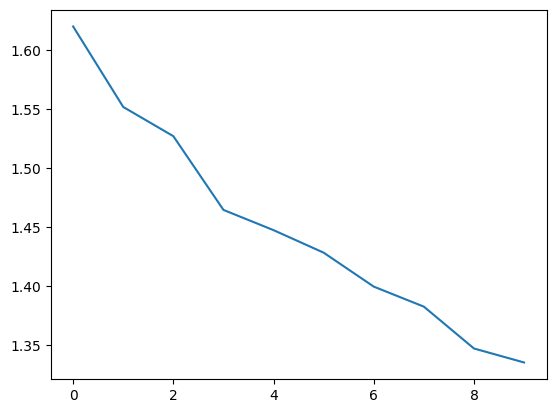

In [ ]:
pyplot.plot(history.history['loss'])

In [ ]:
score = model_mod.evaluate(x_test, [Y_test, y_test])
score

313/313 [==============================] - 2s 5ms/step - loss: 3.5321 - dense_41_loss: 0.8823 - output_loss: 2.9845 - dense_41_acc: 0.7754 - dense_41_mse: 212.0124 - output_acc: 0.1162 - output_mse: 2.9845


[3.532062530517578,
 0.8822700381278992,
 2.984490156173706,
 0.7753999829292297,
 212.01242065429688,
 0.11620000004768372,
 2.984490156173706]

-----

<center><img src='https://drive.google.com/uc?id=1PioHCAlQTt8LWChoMysPErSOrxOfAW0R'></center>